<h1 style="text-align:center;"><b>Evaluation of the objective function by assimilation of TLG  with one hydraulic head data</b></h1>

In this notebook, we evaluate the objective function over the two-dimensional parameter space. TLG and one hydraulic head are assimilated.

This notebook depends on outputs from the gw_flopy notebook, which must be run first.

In [12]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import shutil
import psutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import gravchaw
import pyemu
import flopy
sys.path.insert(0,"..")
import herebedragons as hbd # this function from pyemu notebooks
import mdf_response_surface as resurf # this function from pyemu notebooks

Asuumed that the prerequisite groundwater notebook has already been executed, this cell creates a temporary folder to gather the generated outputs.

In [13]:
# copy created groundwater model

org_d = os.path.join('..', '01_create_gw', 'paper_gw_model')
tmp_d = os.path.join('surf_sq8_noise_joint_case4')

if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)

hbd.prep_bins(tmp_d)

This cell gathers observation data and gravity station coordinates files. 
In this example, both TLG and hydraulic head data are generated from the true model, defined in "gw_flopy", and contaminated with white Gaussian noise with zero mean and standard deviation of $\sim 3\mu\mathrm{Gal}$ and 0.05$\mathrm{m}$, repectively. The required structure for observations is discussed later in this notebook.

In [14]:
# add observation files

obs_path = os.path.join('..', 'lowSNR_observation_data')

shutil.copytree(obs_path, tmp_d, dirs_exist_ok=True)


'surf_sq8_noise_joint_case4'

This cell loads the previously created groundwater model. It serves only as a check to ensure the model runs correctly and is used here solely to extract zones or spatial limits, which is needed later in this notebook to add parameters.

In [15]:
# load simulation

sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)

gwf = sim.get_model()
dis = gwf.dis
ib = gwf.dis.idomain.array[0] # access the idomain

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package wel...
    loading package ghb...
    loading package sfr...
    loading package oc...
    loading package obs...
  loading solution package downsc_freyberg...


Now that all required external files have been added to the temporary folder, we can begin defining the necessary settings to implement the optimization algorithm.

The first step is to instantiate the "PstFrom" object, a pyemu's Class, which constructs the PEST++ interface.

In [16]:
# instantiate PstFrom 

template_ws = os.path.join(f'{tmp_d}_template')
start_datetime="1-1-2008"

pf = pyemu.utils.PstFrom(original_d=tmp_d,   # the folder where the created model is stored
                            new_d=template_ws,  # the pyemu working folder ("the PEST template folder")
                            remove_existing=True,  # "ensures a clean start"
                            longnames=True,  # "set False if using PEST/PEST_HP"
                            zero_based=False,  # "does the MODEL use zero based indices"
                            start_datetime=start_datetime,  # "required when specifying temporal correlation between parameters"
                            echo=False)  # "to stop PstFrom from writting lots of infromation to the notebook"

After constructing PEST++ interface, the next step is instantiate "ModelBridge" object, an interface for preparing and managing inputs for our framework's coupled model.

**Note that "PstFrom" object must be defined first.**

In [17]:
# instantiate ModelBridge 

mb = gravchaw.model_bridge.ModelBridge(working_direct=template_ws,  # the template folder created using "PstFrom" object
                                         pstfrom_obj=pf)  # the object storing "PstFrom"

Now, we add required inputs for the ccoupled model. Let's start with gravity station coordinates. 

**Note that station coordinates must be in meter and stored in an ASCII file.**

In [18]:
# add gravity station coordinates to ModelBridge

mb.add_gravCoor(grav_obs_filename='grav.csv',  # the filename for TLG observations
                        coor_filename='coord_gravstn.csv',  # the filename for TLG station coordinates
                        index_col='station',  # the index column to be used as header in the model output. Station names are recommended.
                        x_col='x(m)',  # the column containing station x coordinates
                        y_col='y(m)',  # the column containing station y coordinates
                        z_col='z(m)')  # # the column containing station z coordinates

{'grav_output_name': 'grav.csv',
 'station_name': ['G000',
  'G001',
  'G002',
  'G003',
  'G004',
  'G005',
  'G006',
  'G007',
  'G008',
  'G009'],
 'x_station': [728.4138455687,
  880.5629516927,
  710.3008567444,
  572.6421416798,
  79.9688456592,
  108.9496277781,
  224.8727562535,
  275.5891249615,
  833.4691807495,
  626.9811081527],
 'y_station': [1924.0703508486,
  1782.7890380192,
  1427.7744570632,
  877.1395968049,
  1474.8682280063,
  1119.8536470503,
  732.2356862106,
  670.651524208,
  228.6945968954,
  127.2618594794],
 'z_station': [66.0313210424,
  64.6444932239,
  62.7723216961,
  64.8550356475,
  90.2815125659,
  86.9680833282,
  72.1098325986,
  69.5567769695,
  59.6112512619,
  55.0933101839]}

TLG is a measure of change between two times, so we need to add simulation time indices. **Note that time indices are zero-based, consistent with the FloPy convention. These values refer to simulation steps used to compute hydraulic heads.** 

In this example, time step 0 is set as one of the required times (the reference), and each subsequent time step is treated as a target.

In [19]:
# add TLG simulation times to ModelBridge

reference_time = [0]
target_time = list(range(1,25))

mb.add_gravTim(reference_time,  # time step index to extract reference heads
               target_time,   # time step index to extract target heads
               pair_type='fixed_side') # to to specify whether time indeices are fixed or flexible sides

(24,
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24])

Corresponding elements form time index pairs to model TLG!

Up to this point, all external and internal inputs required for the coupled model have been prepared. in the next copuple cells, we define inputs to the optimization process. First we add observations to the created "PstFrom" object. Let's discuss some critical points regarding observations file:

**1. Observation files must be in the "template_ws" folder, as we did earlier in the "add observation files" cell.**

**2. Observations must be ASCII files.**

**3. As consistency with model output files are required, observation files are expected to have a header in the first row and an index in the first column. See "head.csv" and "grav.csv" in the "observation_data" folder.**

As we discuss in "weighting observations", all observations can be incorporated at this stage, and their influence on the inversion process controlled through data weighting.

**Note that excpect for observations assimilated in the inversion, we must also add observations corresponding to variables reserved for predictions in the current step.** Through these notebooks, our predictins are hydraulic heads. We can add all hydraulic head observations. In this example, since we are performing an individual inversion of head data, all TLG data weights are set to zero later in this notebook.

In [20]:
# add observation(s) to PstFrom object

# Hydraulic head observations
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

hds_df = pf.add_observations("heads.csv",  # the filename of the observation type
                            insfile="heads.csv.ins",  # the filename of the instruction file (optional). Note that the instruction file is created by pyemu
                            index_cols="time",  # column label or column number (zero-based) to use as index
                            use_cols=list(df.columns.values), # columns including observation values
                            prefix="hds")  # "prefix to all observation names"

# TLG observations
df2 = pd.read_csv(os.path.join(template_ws,"grav.csv"),index_col=0)
df2.head()
hds_df2 = pf.add_observations("grav.csv", # the filename of the observation type
                            insfile="grav.csv.ins", # the filename of the instruction file (optional). Note that the instruction file is created by pyemu
                            index_cols="time", # column label or column number (zero-based) to use as index
                            use_cols=list(df2.columns.values), # columns including observation values
                            prefix="grv") # "prefix to all observation names"

We now define adjustable paramter(s). In this example, hydraulic conductivity and specific yield are the adjustable parameters. We first specify their initial values, and then add them to the "PstFrom" object.

**Note that files containing adjustable paramters must be in the the "template_ws" folder as ascii files.**

In [23]:
# add adjustable parametrs(s) to PstFrom object

# hydraulic conductivity
fhk = 'downsc_freyberg.npf_k.txt'

dirc_k = os.path.join(template_ws, fhk) 
h_k = np.loadtxt(dirc_k, dtype=float)  # read the parameter file

ini_val = 5.0  # intial value for hydraulic conductivity
h_k[h_k==8.0]= ini_val
np.savetxt(dirc_k, h_k, fmt='%.8f') # save initial values as an external file

# here we have shortend the paramter bounds
df_cst = pf.add_parameters(fhk,  # the filename of the adjustable paramter
                    zone_array=ib,  # to exclude inactive cells
                    par_type="constant",  # type of paramterization (our case is constant)
                    par_name_base=fhk.split('.')[1].replace("_","")+"cn",  # specify a name for the paramter
                    pargp=fhk.split('.')[1].replace("_","")+"cn",  # specify a name for the paramter group
                    lower_bound=1.5,  # lower bound of the parameter
                    upper_bound=15.0, # upper bound of the parameter
                    par_style='d')   # parameter style ("m"/"mult"/"multiplier", "a"/"add"/"addend", or "d"/"direct")

# specific yield
fsy = 'downsc_freyberg.sto_sy.txt'

dirc_sy = os.path.join(template_ws, fsy)
sy = np.loadtxt(dirc_sy, dtype=float)  # read the parameter file

ini_val = 0.005 # initial value for specific yield
sy[sy==0.25]= ini_val
np.savetxt(dirc_sy, sy, fmt='%.8f') # save initial values as an external file

df_cst = pf.add_parameters(fsy,  # the filename of the adjustable paramter
                    zone_array=ib,  # to exclude inactive cells
                    par_type="constant",  # type of paramterization (our case is constant)
                    par_name_base=fsy.split('.')[1].replace("_","")+"cn",  # specify a name for the paramter
                    pargp=fsy.split('.')[1].replace("_","")+"cn",  # specify a name for the paramter group
                    lower_bound=1.0E-3,  # lower bound of the parameter
                    upper_bound=1.0,  # upper bound of the parameter
                    par_style='d')  # parameter style ("m"/"mult"/"multiplier", "a"/"add"/"addend", or "d"/"direct")

"PstFrom" object must access to the coupled model. In this cell, "ModelBridge" object manages it:

In [24]:
# add the coupled model to Modelbridge

mb.add_coupmodel_out()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package wel...
    loading package ghb...
    loading package sfr...
    loading package oc...
    loading package obs...
  loading solution package downsc_freyberg...


After adding the model, we build the pst object:

In [25]:
# build the pst object

pst = pf.build_pst()

noptmax:0, npar_adj:2, nnz_obs:565


We see the number of iterations (noptmax), adjustable parameters (npar_adj), and observations (nnz_obs). In the following cells we update the number of iterations and observations.

In [26]:
# define the number of iterations to be used in the optimization process

itr = 0  
pst.control_data.noptmax = itr  # add the number of iteration to the pst file. By default iterations is zero.

By adding the observation files and build the pst file, observations are weighted 1, by default, and assimilated in the optimization process. In this cell by updating the weight, we decide which data to be assimilated.


**Note that observations that are reserved for predictions (forcast) must be weighted zero.** In this case, TLG data are excluded.

In [27]:
# weight observations

obs = pst.observation_data

obs.loc[:, 'weight'] = 0

obs.loc[(obs.usecol=="trgw-0-3-8") & (obs['time'].str.split('-').str[0].astype(float)<=4018.5), "weight"] = 20 
obs.loc[(obs.usecol=="trgw-0-3-8") & (obs['time'].str.split('-').str[0].astype(float)==3652.5), "weight"] = 0

obs.loc[(obs.oname=="grv") & (obs['time'].str.split('-').str[1].astype(float)<=4018.5), "weight"] = 1/np.sqrt(8.0)

Here we define state variable(s) to make predictions. Hydraulic heads at three points at the end of the simulation (day 4383.5) are set as forcast:

In [28]:
# define state variable(s) to make predictions

forecasts = ['oname:hds_otype:lst_usecol:trgw-0-15-16_time:4383.5',
              'oname:hds_otype:lst_usecol:trgw-0-2-15_time:4383.5',
              'oname:hds_otype:lst_usecol:trgw-0-2-9_time:4383.5']

pst.pestpp_options['forecasts'] = forecasts

Update the pst object:

In [29]:
# write the pst file

pst.write(os.path.join(template_ws, f'{tmp_d}.pst'), version=1)

noptmax:0, npar_adj:2, nnz_obs:132


Find the number of workers on your machine:

In [31]:
num_workers = psutil.cpu_count(logical=False)
num_workers

16

The final step involves running the "pestpp-swp" algorithm to evaluate the objective function over the two dimensional parameter space.

In [32]:
# evaluate objective function
gw_respsurf_d = "noisy_surface_one_head_grav"
shutil.copytree(template_ws, gw_respsurf_d)
resurf.run_respsurf(par_names=['pname:npfkcn_inst:0_ptype:cn_pstyle:d','pname:stosycn_inst:0_ptype:cn_pstyle:d'],
                    pstfile=f'{tmp_d}.pst', 
                    WORKING_DIR=gw_respsurf_d,
                    num_workers=num_workers)

noptmax:0, npar_adj:2, nnz_obs:132


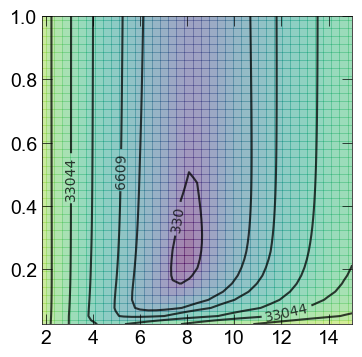

In [33]:
# plot objective function response-surface

fig, ax, resp_surf = resurf.plot_response_surface(figsize=(4,4),
                                                  pstfile=f'{tmp_d}.pst',
                                                  WORKING_DIR=gw_respsurf_d) 